In [357]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error as mse
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import  make_column_transformer
import joblib
import warnings
warnings.filterwarnings('ignore')

In [564]:
df = pd.read_csv('Quikr_car.csv', index_col=0)
df

,Name,Label,Location,Price,Kms_driven,Fuel_type,Owner,Year,Company
0,Ford Figo Duratec Petrol EXI 1.2 - 2015,PLATINUM,Bangalore,"₹3,80,000","35,056 kms",Petrol,NaN,2015,Ford
1,Maruti Suzuki Wagon R VXI BS IV - 2016,PLATINUM,Bangalore,"₹4,65,000","44,000 kms",Petrol,NaN,2016,Maruti
2,Hyundai Creta 1.6 SX PLUS AUTO PETROL - 2018,PLATINUM,Bangalore,"₹13,50,000","42,917 kms",Petrol,NaN,2018,Hyundai
3,Hyundai Venue - 2019,PLATINUM,Chennai,"₹10,19,699","16,112 kms",Petrol,2nd Owner,2019,Hyundai
4,Honda Jazz - 2017,PLATINUM,Pune,"₹7,13,499","30,988 kms",Petrol,2nd Owner,2017,Honda
...,...,...,...,...,...,...,...,...,...
1027,Hyundai i10 Magna 1.2 - 2014,GOLD,Bangalore,"₹2,29,000","65,000 kms",Petrol,1st Owner,2014,Hyundai
1028,Maruti Suzuki Alto K10 LXi CNG - 2014,GOLD,Bangalore,"₹2,75,000","60,000 kms",Petrol,NaN,2014,Maruti
1029,Jeep Compass Limited 2.0 Diesel - 2017,GOLD,Mahasamund,"₹17,50,000","31,000 kms",Diesel,1st Owner,2017,Jeep
1030,Jeep Compass Limited 2.0 Diesel - 2017,GOLD,Bilaspur,"₹17,50,000","31,000 kms",Diesel,1st Owner,2017,Jeep


In [565]:
df.shape

(1032, 9)

In [566]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1032 entries, 0 to 1031
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Name        1032 non-null   object
 1   Label       1032 non-null   object
 2   Location    1030 non-null   object
 3   Price       1032 non-null   object
 4   Kms_driven  1032 non-null   object
 5   Fuel_type   1032 non-null   object
 6   Owner       740 non-null    object
 7   Year        1032 non-null   int64 
 8   Company     1032 non-null   object
dtypes: int64(1), object(8)
memory usage: 80.6+ KB


In [567]:
# missing values in %
df.isnull().sum() / df.shape[0] * 100

Name           0.000000
Label          0.000000
Location       0.193798
Price          0.000000
Kms_driven     0.000000
Fuel_type      0.000000
Owner         28.294574
Year           0.000000
Company        0.000000
dtype: float64

# EDA (exploratory data analysis)

In [568]:
#drop null values and owner column
df.drop('Owner', axis=1, inplace=True)
df.dropna(axis=0, inplace=True)

In [569]:
df.duplicated().sum()

12

In [570]:
df.drop_duplicates(keep='first', inplace=True)

In [571]:
df.shape

(1018, 8)

In [572]:
# change data type and remove comma, kms
df['Kms_driven'] = df['Kms_driven'].str.replace(',', '').str.replace('kms ', '').astype(int)

In [573]:
# change data type and remove incorrect value
df = df[df['Price'] != 'Ask For Price']
df['Price'] = df['Price'].str.replace('₹', '').str.replace(',', '').astype(int)

In [574]:
df['Fuel_type'].unique()

array([' Petrol', ' Petrol ', ' Diesel ', ' Diesel', ' Electric ', ' CNG',
       ' LPG', ' Petrol + CNG ', ' Hybrid ', ' CNG '], dtype=object)

In [575]:
#remove spacd from sides
df['Fuel_type'] = df['Fuel_type'].str.strip()

In [576]:
df

,Name,Label,Location,Price,Kms_driven,Fuel_type,Year,Company
0,Ford Figo Duratec Petrol EXI 1.2 - 2015,PLATINUM,Bangalore,380000,35056,Petrol,2015,Ford
1,Maruti Suzuki Wagon R VXI BS IV - 2016,PLATINUM,Bangalore,465000,44000,Petrol,2016,Maruti
2,Hyundai Creta 1.6 SX PLUS AUTO PETROL - 2018,PLATINUM,Bangalore,1350000,42917,Petrol,2018,Hyundai
3,Hyundai Venue - 2019,PLATINUM,Chennai,1019699,16112,Petrol,2019,Hyundai
4,Honda Jazz - 2017,PLATINUM,Pune,713499,30988,Petrol,2017,Honda
...,...,...,...,...,...,...,...,...
1027,Hyundai i10 Magna 1.2 - 2014,GOLD,Bangalore,229000,65000,Petrol,2014,Hyundai
1028,Maruti Suzuki Alto K10 LXi CNG - 2014,GOLD,Bangalore,275000,60000,Petrol,2014,Maruti
1029,Jeep Compass Limited 2.0 Diesel - 2017,GOLD,Mahasamund,1750000,31000,Diesel,2017,Jeep
1030,Jeep Compass Limited 2.0 Diesel - 2017,GOLD,Bilaspur,1750000,31000,Diesel,2017,Jeep


In [577]:
cars_name = """Maruti Suzuki 800
Maruti Suzuki Alto
Maruti Suzuki Alto 800
Maruti Suzuki Alto K10
Maruti Suzuki Baleno
Maruti Suzuki Vitara Brezza
Maruti Suzuki Celerio
Maruti Suzuki Ciaz
Maruti Suzuki Dzire
Maruti Suzuki Eeco
Maruti Suzuki Ertiga
Maruti Suzuki Gypsy
Maruti Suzuki Ignis
Maruti Suzuki Omni
Maruti Suzuki Ritz
Maruti Suzuki S-Cross
Maruti Suzuki S-Presso
Maruti Suzuki Swift
Maruti Suzuki SX4
Maruti Suzuki Wagon R
Maruti Suzuki XL6
Maruti Suzuki Zen Estilo
Hyundai Accent
Hyundai Creta
Hyundai Elite i20
Hyundai EON
Hyundai Getz
Hyundai Grand i10
Hyundai Grand i10 NIOS
Hyundai i10
Hyundai i20
Hyundai i20 Active
Hyundai Santa Fe
Hyundai Santro
Hyundai Venue
Hyundai Verna
Hyundai Xcent
Honda Accord
Honda Amaze
Honda BR-V
Honda Brio
Honda City
Honda Civic
Honda CR-V
Honda Jazz
Honda WR-V
Toyota Corolla
Toyota Corolla Altis
Toyota Etios
Toyota Etios Liva
Toyota Fortuner
Toyota Glanza
Toyota Innova
Toyota Innova Crysta
Toyota Yaris
Ford EcoSport
Ford Endeavour
Ford Figo
Ford Figo Aspire
Ford Freestyle
Ford Ikon
Tata Aria
Tata Harrier
Tata Hexa
Tata Indica
Tata Indica Vista
Tata Indigo
Tata Nano
Tata Nexon
Tata Tiago
Tata Tigor
Tata Zest
Mahindra Bolero
Mahindra Jeep CL
Mahindra KUV100
Mahindra Logan
Mahindra Marazzo
Mahindra Scorpio
Mahindra Thar
Mahindra TUV300
Mahindra Verito
Mahindra XUV 500
Mahindra Xylo
Volkswagen Ameo
Volkswagen Polo
Volkswagen Vento
Renault Captur
Renault Duster
Renault Kwid
Renault Lodgy
Renault Pulse
Renault Scala
Renault Triber
Kia Carnival
Kia Seltos
Kia Sonet
MG Motors Hector
Skoda Laura
Skoda Rapid
BMW 3 Series
BMW 5 Series
BMW X5
Audi Q3
Audi Q5
Audi Q7
Mercedes-Benz C-Class
Mercedes-Benz E-Class
Mercedes-Benz GL-Class
Mercedes-Benz GLE Coupe
Volvo XC60
Volvo XC90
Jeep Compass
Jaguar XF
Jaguar XJ
Land Rover Range Rover Evoque
Porsche Cayenne
Chevrolet Aveo
Chevrolet Beat
Chevrolet Cruze
Chevrolet Optra
Chevrolet Sail
Chevrolet Spark
Fiat Linea
Fiat Punto
Nissan Micra
Nissan Micra Active
Nissan Terrano
Datsun GO
Datsun Redi-GO
SsangYong Rexton
"""

In [578]:
# concat all car name 
cars_name = cars_name.replace('\n', ', ')
name = ''
for i in df['Name']:
    for j in i.split():
        if j in cars_name:
            name = name + ' ' + j

In [579]:
#all car name append in the list
car_name_list = []
for i in name.split('-'):
    car_name_list.append(i)

In [580]:
df['Name'] = car_name_list[:-1]
df

,Name,Label,Location,Price,Kms_driven,Fuel_type,Year,Company
0,Ford Figo,PLATINUM,Bangalore,380000,35056,Petrol,2015,Ford
1,Maruti Suzuki Wagon R,PLATINUM,Bangalore,465000,44000,Petrol,2016,Maruti
2,Hyundai Creta SX,PLATINUM,Bangalore,1350000,42917,Petrol,2018,Hyundai
3,Hyundai Venue,PLATINUM,Chennai,1019699,16112,Petrol,2019,Hyundai
4,Honda Jazz,PLATINUM,Pune,713499,30988,Petrol,2017,Honda
...,...,...,...,...,...,...,...,...
1027,Hyundai i10,GOLD,Bangalore,229000,65000,Petrol,2014,Hyundai
1028,Maruti Suzuki Alto K10,GOLD,Bangalore,275000,60000,Petrol,2014,Maruti
1029,Jeep Compass,GOLD,Mahasamund,1750000,31000,Diesel,2017,Jeep
1030,Jeep Compass,GOLD,Bilaspur,1750000,31000,Diesel,2017,Jeep


In [581]:
#remove space from sides
df['Name'] = df['Name'].str.strip()

In [582]:
df.drop('Label', axis=1, inplace=True)

In [583]:
#checking duplicates
df.duplicated().sum()

4

In [584]:
df.drop_duplicates(keep='first', inplace=True)

In [585]:
df.describe()

,Price,Kms_driven,Year
count,1.008000e+03,1008.000000,1008.000000
mean,6.828920e+05,50147.823413,2015.818452
std,5.349223e+05,37995.641700,3.353070
min,3.900000e+04,0.000000,2000.000000
25%,4.110990e+05,26368.500000,2014.000000
50%,5.580490e+05,44000.000000,2016.000000
75%,7.854498e+05,67000.000000,2018.000000
max,7.500000e+06,690000.000000,2022.000000


# Visualization

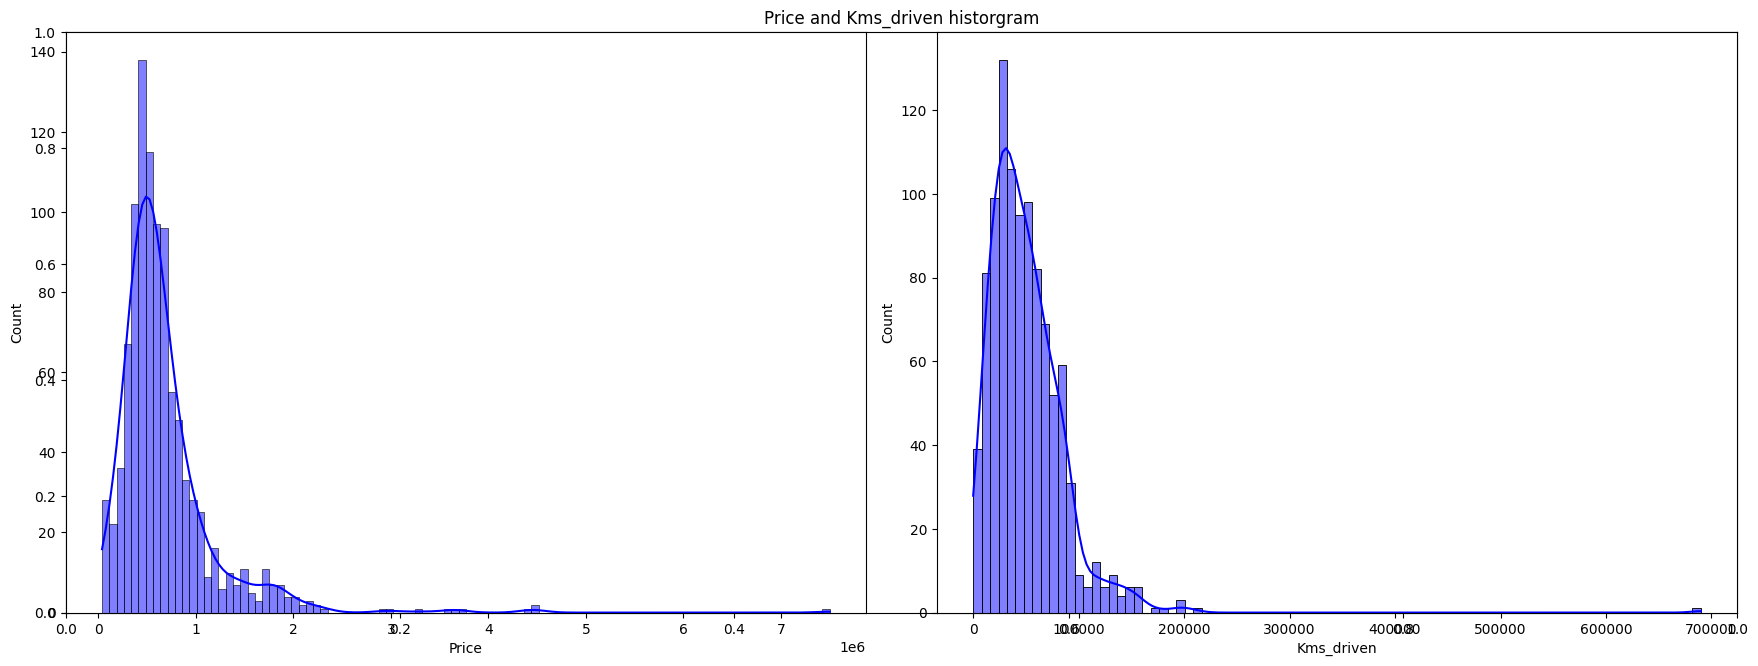

In [586]:
plt.figure(figsize=[18, 7])
plt.title('Price and Kms_driven historgram')
for i, j in enumerate(df.columns[2:4]):
    plt.subplot(1, 2, i+1)
    sns.histplot(x=df[j], color='blue', kde=True)
    plt.xlabel(j)
    plt.tight_layout();

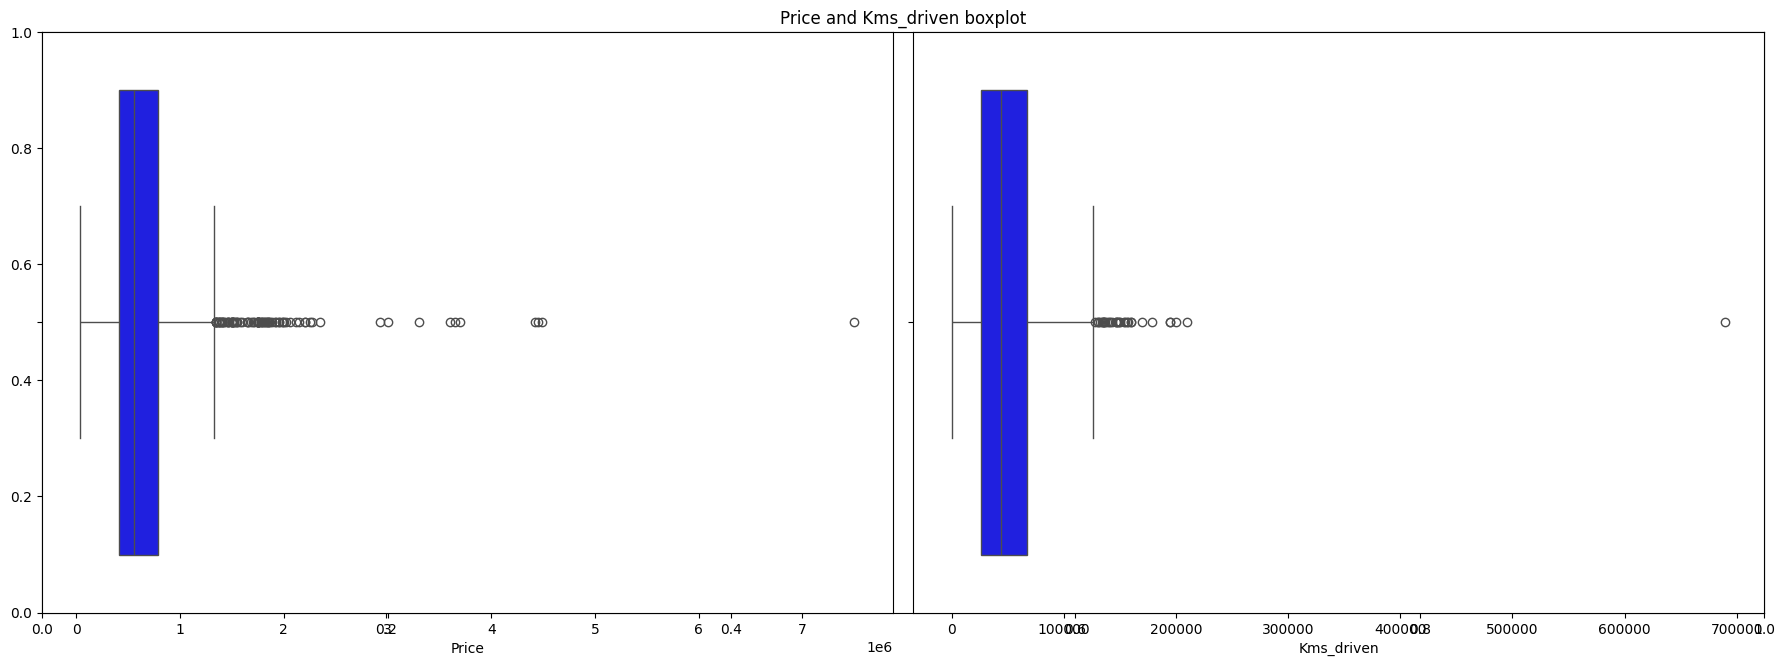

In [587]:
plt.figure(figsize=[18, 7])
plt.title('Price and Kms_driven boxplot')
for i, j in enumerate(df.columns[2:4]):
    plt.subplot(1, 2, i+1)
    sns.boxplot(x=df[j], color='blue')
    plt.xlabel(j)
    plt.tight_layout();

In [588]:
# remove outliers
df = df[df['Price'] < 5000000]
df = df[df['Kms_driven'] < 300000]

In [590]:
#log transform
df['Price'] = np.log1p(df['Price'])

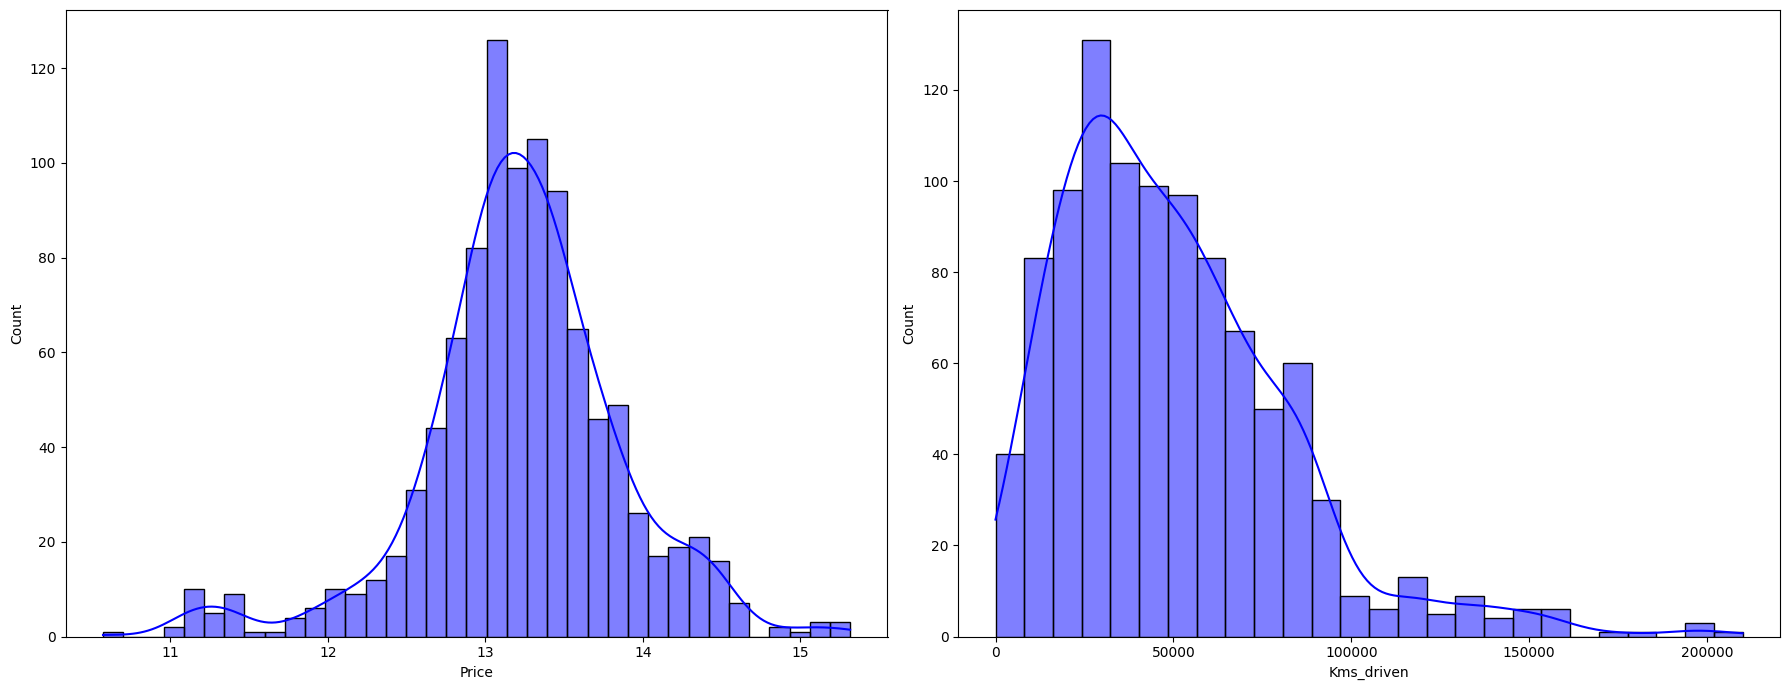

In [591]:
plt.figure(figsize=[18, 7])
for i, j in enumerate(df.columns[2:4]):
    plt.subplot(1, 2, i+1)
    sns.histplot(x=df[j], color='blue', kde=True)
    plt.xlabel(j)
    plt.tight_layout();

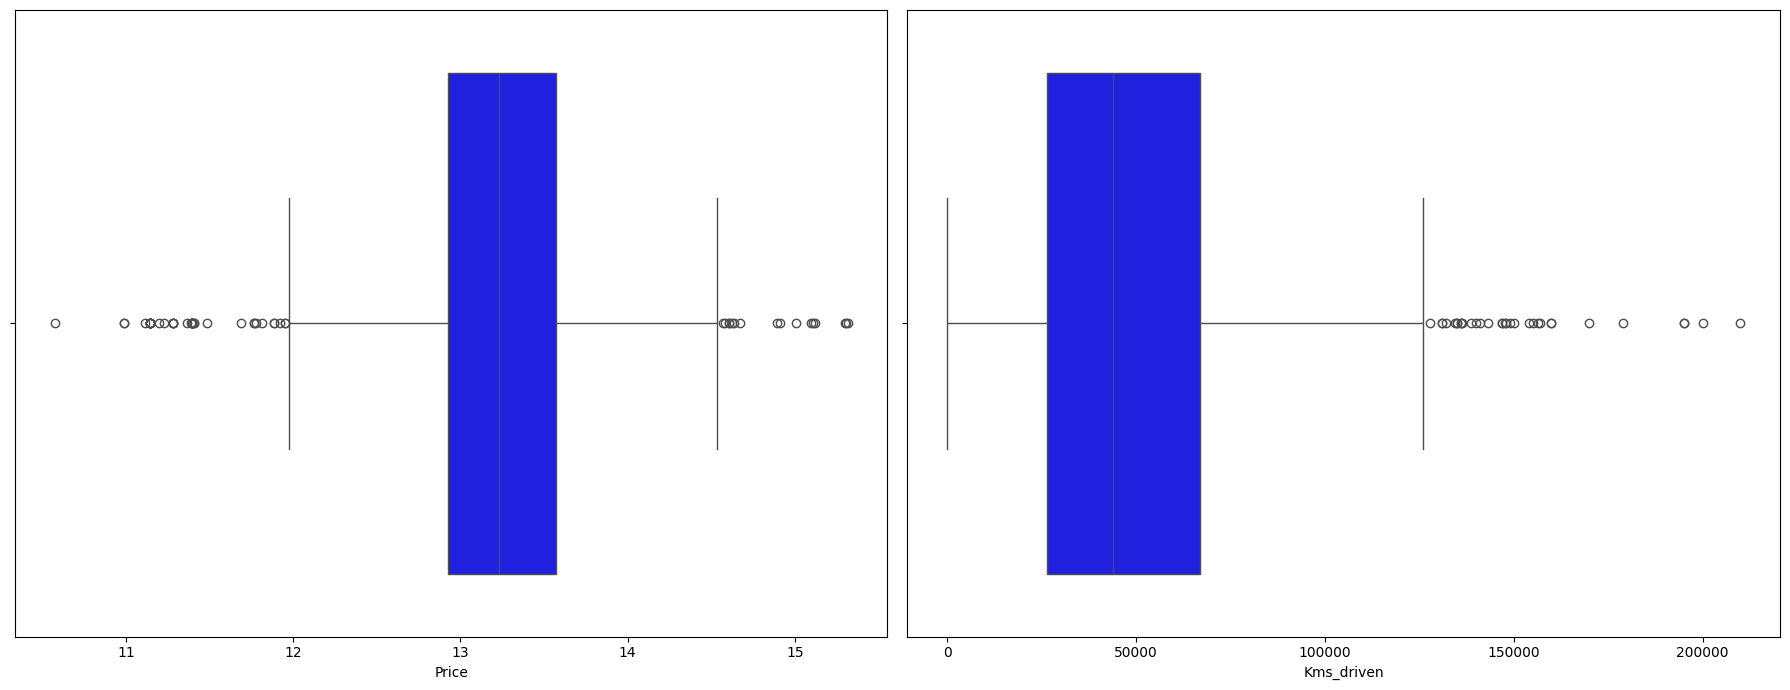

In [592]:
plt.figure(figsize=[18, 7])
for i, j in enumerate(df.columns[2:4]):
    plt.subplot(1, 2, i+1)
    sns.boxplot(x=df[j], color='blue')
    plt.xlabel(j)
    plt.tight_layout();

In [593]:
x = df.drop('Price', axis=1)
y = df['Price']

# modeling

In [594]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=5)

In [595]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe.fit(x[['Name', 'Location', 'Fuel_type', 'Company']])
lr = LinearRegression()
robust = RobustScaler()

In [596]:
column_transform = make_column_transformer((OneHotEncoder(categories=ohe.categories_, sparse_output=False, drop='first'), ['Name', 'Location', 'Fuel_type', 'Company']), 
                                           remainder='passthrough')

Create pipeline

In [597]:
pipe = make_pipeline(column_transform, robust, lr)
pipe.fit(x_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('robustscaler', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('onehotencoder', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the diffe

In [598]:
#training accuracy
r2_score(y_train, pipe.predict(x_train))

0.9586965951162418

In [599]:
#testing accuracy
r2_score(y_test, pipe.predict(x_test))

0.9157011044730693

In [600]:
#error
mse(y_test, pipe.predict(x_test))

0.033786159995782314

checking which random state best for model

In [601]:
lr = LinearRegression()
train = []
test = []
for i in range(20):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=i)
    lr = LinearRegression()
    pipe = make_pipeline(column_transform, lr)
    pipe.fit(x_train, y_train)
    y_pred_test = pipe.predict(x_test)
    y_pred_train = pipe.predict(x_train)
    train.append(r2_score(y_train, y_pred_train))
    test.append(r2_score(y_test, y_pred_test))

In [602]:
train

[0.9601019547580585,
 0.9657795377728621,
 0.961216510392438,
 0.9586169233287899,
 0.9647586905126792,
 0.9586965951162421,
 0.9641173675994172,
 0.9683849181102002,
 0.9649667864665022,
 0.9620185734494736,
 0.9649905496146383,
 0.9625434963394791,
 0.9621852833418424,
 0.9602176566542678,
 0.96454415020321,
 0.9647089844998067,
 0.965046875054766,
 0.9621768127153092,
 0.9687398406293863,
 0.9619748814919145]

In [603]:
test

[0.8700415876139997,
 0.82917971595837,
 0.8894665765045648,
 0.8909582998188131,
 0.8595841368892951,
 0.9157011044720851,
 0.8741471585226501,
 0.8060509719383374,
 0.8802306382620849,
 0.852670652099344,
 0.841470139653266,
 0.8751118194079498,
 0.8912594787649634,
 0.8278759631241596,
 0.8599659821105942,
 0.8597311190532504,
 0.83548240591556,
 0.8478740768965121,
 0.8513678159479061,
 0.8678028152999384]

In [ ]:
joblib.dump(pipe, 'pipe.pkl')
joblib.dump(x, 'feature.pkl')